In [2]:
import optimization_SPDC
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

# Initialize the parameters to build U matrix

In [3]:
# power of the pump
Np = 0.01
# create the frequency matrix ω-ω_mean 
N = 501
wi = -7
wf = 7
x = np.linspace(wi, wf, N)
# get the group velocities for all modes
vp = 0.1
sigma = 1
a = 1.61/1.13
l = 1
def symmetric_v(vp, sigma, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sigma))
    vs = vp / (1 + 2 * a * vp / (l * sigma))
    return vs, vi
vs, vi = symmetric_v(vp, sigma, l, a)
# prefactor to multiply pump with to obtain F matrix
alpha = np.sqrt(Np)*(x[len(x) - 1] - x[0])/(len(x) - 1)/(np.sqrt(2 * np.pi * vs * vi * vp))
# initialize the G and H matrices without cross phase modulation
G = np.diag((1/vs - 1/vp)*x)
H = np.diag((1/vi - 1/vp)*x)

# Initialize the desired value for mean pair number (N) and Schmidt number (K)

In [4]:
y_N = 2
y_K = 1

# Train the model 

In [5]:
# add a complex phase
phi = np.random.random()
# initializing with a gaussian pump can limit the noise of the optimized result
a = 0.2*jnp.exp(-(jnp.linspace(2*wi, 2*wf, 2*N))**2)*np.exp(1j*phi)
for i in range(500):
    if i%100 == 0:
        print("loss on K value: ", optimization_SPDC.get_euclidean_loss_K(a, N, alpha, G, H, l, y_K))
        print("loss on N value: ", optimization_SPDC.get_euclidean_loss_N(a, N, alpha, G, H, l, y_N))
    a = optimization_SPDC.update(a, N, alpha, G, H, l, y_N, y_K)

loss on K value:  0.07985268
loss on N value:  3.6784925
loss on K value:  0.014253092
loss on N value:  7.633033e-06
loss on K value:  0.014014067
loss on N value:  8.435627e-06
loss on K value:  0.014254145
loss on N value:  1.0237295e-05
loss on K value:  0.015145462
loss on N value:  1.404348e-05


# Show the JSA power map 

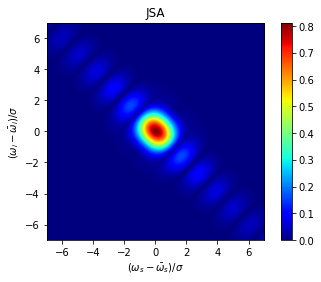

In [6]:
JSA = optimization_SPDC.get_JSA(x, a, N, alpha, G, H, l)
fig, ax = plt.subplots()
im = ax.imshow(JSA, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_title("JSA")
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
plt.colorbar(im, orientation="vertical")
plt.show()

# Show the pump envelopp

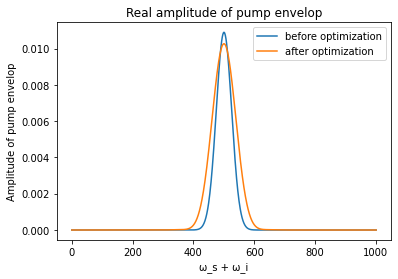

In [12]:
initial_pump = jnp.exp(-(jnp.linspace(2*wi, 2*wf, 2*N))**2)*np.exp(1j*phi)
plt.title("Real amplitude of pump envelop")
plt.xlabel("ω_s + ω_i")
plt.ylabel("Amplitude of pump envelop")
plt.plot(jnp.real(initial_pump/sum(jnp.abs(initial_pump))), label = "before optimization")
plt.plot(jnp.real(a/sum(jnp.abs(a))), label = "after optimization")
plt.legend()

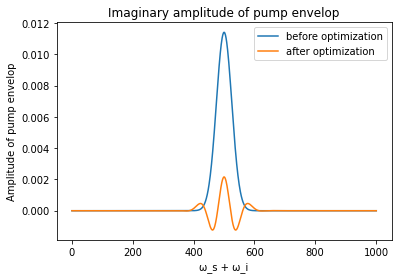

In [13]:
plt.title("Imaginary amplitude of pump envelop")
plt.xlabel("ω_s + ω_i")
plt.ylabel("Amplitude of pump envelop")
plt.plot(jnp.imag(initial_pump/sum(jnp.abs(initial_pump))), label = "before optimization")
plt.plot(jnp.imag(a/sum(jnp.abs(a))), label = "after optimization")
plt.legend()

In [14]:
optimization_SPDC.get_observables(a, N, alpha, G, H, l)

(DeviceArray(2.0048006, dtype=float32), DeviceArray(1.1310575, dtype=float32))